Final Exam: K Nearest Neighbors

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pymysql

In [2]:
# Establish Connection
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='v7vsiuel',
                             db='cds695',
                             cursorclass=pymysql.cursors.DictCursor)
cursor = connection.cursor()

In [3]:
# Read Directors data from database

sql_query = """
SELECT
    institution.Institutions,
    companies_combined.FullName As Company_Name,
    countries.country AS Resident_Country,
    people.FullName

FROM people
    LEFT JOIN educationofeople on educationofeople.People_ID = people.Dir_ID
    LEFT JOIN institution on institution.Institutions_ID = educationofeople.Institutions_ID
    LEFT JOIN countries on countries.country_ID = people.Resident_Countr_ID
    LEFT JOIN peopleandcompanies on peopleandcompanies.People_ID = people.Dir_ID
    LEFT JOIN companies_combined on companies_combined.Company_ID = peopleandcompanies.Company_ID
"""

df_directors = pd.read_sql(sql_query, connection)


col_names = df_directors.columns.tolist()
print(col_names)
# print(df_directors.head)
print("Directors data read successfully!")
df_directors.shape

['Institutions', 'Company_Name', 'Resident_Country', 'FullName']
Directors data read successfully!


(8184, 4)

In [4]:
print(df_directors.dtypes)

# df_directors['FullName'] = df_directors.FullName.astype(str)
# df_directors['Institutions'] = df_directors.Institutions.astype(str)
# df_directors['Company_Name'] = df_directors.Company_Name.astype(str)
# df_directors['Resident_Country'] = df_directors.Resident_Country.astype(str)



# df_directors['FullName'] = pd.Categorical(df_directors.FullName)
# df_directors['Institutions'] = pd.Categorical(df_directors.Institutions)
# df_directors['Company_Name'] = pd.Categorical(df_directors.Company_Name)
# df_directors['Resident_Country'] = pd.Categorical(df_directors.Resident_Country)

# df_directors[['FullName', 'Institutions', 'Company_Name', 'Resident_Country']] = df_directors[['FullName', 'Institutions', 'Company_Name', 'Resident_Country']].astype(str) 
# print(df_directors.dtypes)

# print(df_directors.isnull().sum()) # count the missing values in each column
df_directors.dropna(inplace=True)
print(df_directors.shape)
print(df_directors.isnull().sum()) # count the missing values in each column
# df_directors.Education_title.fillna(value='no_title', inplace=True) 
# df_directors.Company_Name.fillna(value='No_company', inplace=True) 
# df_directors.Resident_Country.fillna(value='Na', inplace=True) 
# df_directors.Role.fillna(value='no_role', inplace=True) 
# df_directors.Rank.fillna(value='no_rank', inplace=True) 
# df_directors.Branch.fillna(value='no_branch', inplace=True)
# df_directors.Institutions.fillna(value='no_institution', inplace=True)
print(df_directors.shape)
print(df_directors.dtypes)
# print(df_directors.isnull().sum()) # count the missing values in each column

Institutions        object
Company_Name        object
Resident_Country    object
FullName            object
dtype: object
(1127, 4)
Institutions        0
Company_Name        0
Resident_Country    0
FullName            0
dtype: int64
(1127, 4)
Institutions        object
Company_Name        object
Resident_Country    object
FullName            object
dtype: object


In [5]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_directors = df_directors.index.size
n_features = df_directors.columns.size - 1
n_usa_residence = df_directors[df_directors['Resident_Country'] == 'USA\r' ].index.size
n_international_residence = n_directors - n_usa_residence
usa_rate = 100*float(n_usa_residence) / float(n_directors)
print("Total number of n_directors: {}".format(n_directors))
print("Number of n_directors who n_usa_residence: {}".format(n_usa_residence))
print("Number of n_directors who n_international_residence: {}".format(n_international_residence))
print("Number of features: {}".format(n_features))
print("Percentage of USA residence of the directors: {:.2f}%".format(usa_rate))

Total number of n_directors: 1127
Number of n_directors who n_usa_residence: 379
Number of n_directors who n_international_residence: 748
Number of features: 3
Percentage of USA residence of the directors: 33.63%


In [6]:
# Extract feature (X) and target (y) columns
feature_cols = list(df_directors.columns[:-1])  # all columns but last are features
target_col = df_directors.columns[-1]  # last column is the target/label
print("Feature column(s):-\n{}".format(feature_cols))
print("Target column: {}".format(target_col))

X_all = df_directors[feature_cols]  # feature values for all students
y_all = df_directors[target_col]  # corresponding targets/labels
print("\nFeature values:-")
print(X_all.head())  # print the first 5 rows
print(y_all.head())  # print the first 5 rows



Feature column(s):-
['Institutions', 'Company_Name', 'Resident_Country']
Target column: FullName

Feature values:-
             Institutions                                      Company_Name  \
0  H.E.C. Business School                                 LAZARD BROTHERS\r   
2  H.E.C. Business School                                    PERMAL FUNDS\r   
3  H.E.C. Business School              PERMAL GROUP (DIFFERENT COMPANIES)\r   
4  H.E.C. Business School         PERMAL INVESTMENT FUND SERVICES LIMITED\r   
5  H.E.C. Business School  SICAVS / BANQUE NATIONALE DE PARIS GROUP (BNP)\r   

  Resident_Country  
0         France\r  
2         France\r  
3         France\r  
4         France\r  
5         France\r  
0    EDMOND DE LA HAYE JOUSSELIN
2    EDMOND DE LA HAYE JOUSSELIN
3    EDMOND DE LA HAYE JOUSSELIN
4    EDMOND DE LA HAYE JOUSSELIN
5    EDMOND DE LA HAYE JOUSSELIN
Name: FullName, dtype: object


In [7]:
# Preprocess feature columns "Hot Encoding"
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
#         # If data type is non-numeric, try to replace all yes/no values with 1/0
#         if col_data.dtype == object:
#             col_data = col_data.replace(['yes', 'no'], [1, 0])
#         # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
#         if col_data.dtype == object:
        col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
# y_all = y_all.replace(['yes','no'],[1,0])
print("Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (862):-
['Institutions_Aberdeen University', 'Institutions_Auckland University', 'Institutions_Bates College', 'Institutions_Bocconi University', 'Institutions_Boston University', 'Institutions_Brandeis University', 'Institutions_Brock University', 'Institutions_Bucknell University', 'Institutions_Cambridge University', 'Institutions_Carnegie Mellon University  Tepper School', 'Institutions_College Stanislas', 'Institutions_College of Europe', 'Institutions_College of William and Mary', 'Institutions_Columbia University', 'Institutions_Commercial School of Business Administration', 'Institutions_Cornell University', 'Institutions_DePaul University', 'Institutions_ENSIMAG', 'Institutions_ETH', 'Institutions_Emory University', 'Institutions_Free University', 'Institutions_GSB', 'Institutions_Georgetown university', 'Institutions_Glasgow University', 'Institutions_Graduate Institute of International Studies', 'Institutions_Graduate School of Management in Los Ang

In [85]:
# First, decide how many training vs test samples you want
num_all = df_directors.shape[0]  # same as len(student_data)
num_train = int(.75 * num_all)  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_all , y_all , test_size = num_test, random_state=42)

print("Training set: {} samples".format(X_train.shape[0]))
print("Test set: {} samples".format(X_test.shape[0]))
# Note: If you need a validation set, extract it from within training data

Training set: 845 samples
Test set: 282 samples


In [86]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    #print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    #print "Training time (secs): {:.7f}".format(end - start)
    return end-start

In [87]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Prediction time (secs): {:.7f}".format(end - start)
#     return precision_score(target.values, y_pred), end-start
    return f1_score(target.values, y_pred, pos_label=1, average='weighted'), end-start

In [88]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    #print "------------------------------------------"
    #print "Training set size: {}".format(len(X_train))
    training_time = train_classifier(clf, X_train, y_train)
    F1_train, pred_time_train = predict_labels(clf, X_train, y_train)
    F1_test, pred_time_test = predict_labels(clf, X_test, y_test)
    print("{:d} | {:5f} | {:5f} / {:5f} | {:5f} / {:5f} ".format(len(X_train) ,\
                                                                 training_time,\
                                                                 pred_time_train,\
                                                                 pred_time_test,\
                                                                 F1_train, F1_test ))
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

In [90]:
# TODO: Train and predict using two other models
# TODO: Choose a model, import it and instantiate an object
num_train_arr = [100,200,300]

from sklearn.neighbors import KNeighborsClassifier

dt_clf = DecisionTreeClassifier(random_state = 32)
nb_clf = BernoulliNB()
knn_clf = KNeighborsClassifier(metric='jaccard')
# clf_arr = [dt_clf,nb_clf,knn_clf]
clf_arr = [knn_clf]



for clf in clf_arr:
    print("Training {}...".format(clf.__class__.__name__))
    print('X_train_length | training_time / pred_time_train / pred_time_test | F1_train / F1_test')
    for num_train in num_train_arr:
        f1_dt = train_predict( clf , X_train[0:num_train], y_train[0:num_train], X_test, y_test )



Training KNeighborsClassifier...
X_train_length | training_time / pred_time_train / pred_time_test | F1_train / F1_test
100 | 0.001113 | 0.011172 / 0.030772 | 0.324912 / 0.093520 
200 | 0.001931 | 0.043268 / 0.062452 | 0.502690 / 0.270610 


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


300 | 0.003499 | 0.096789 / 0.084509 | 0.614627 / 0.432115 


In [13]:
#Fitting k-NN to taining set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(metric='jaccard')
classifier.fit(X_train[0:num_train], y_train[0:num_train])

y_pred = classifier.predict(X_train[0:num_train])
#MakingConfusionMatrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train[0:num_train],y_pred)

print(classifier.score(X_train[0:num_train], y_train[0:num_train]))

0.683333333333



The accuracy of the knn classifier for k = 3 is 79%


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot


The optimal number of neighbors is 3.


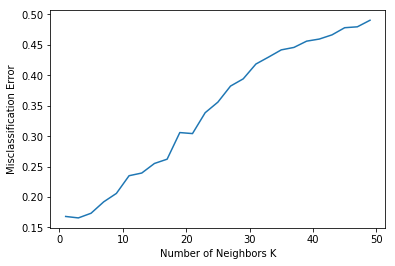

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter

# ============================== KNN with k = 3 ===============================================
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = 3 is %d%%' % acc)
# ============================== parameter tuning =============================================
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
#     knn = KNeighborsClassifier(n_neighbors=k)
    knn = KNeighborsClassifier(metric='jaccard', n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

[0.83687943262411346, 0.8014184397163121, 0.8014184397163121, 0.7978723404255319, 0.79078014184397161, 0.77304964539007093, 0.76950354609929073, 0.75886524822695034, 0.75886524822695034, 0.74468085106382975, 0.71985815602836878, 0.71985815602836878, 0.71631205673758869, 0.71276595744680848, 0.6985815602836879, 0.68794326241134751, 0.66666666666666663, 0.67021276595744683, 0.60992907801418439, 0.61702127659574468, 0.61702127659574468, 0.61347517730496459, 0.5957446808510638, 0.59219858156028371, 0.56737588652482274]


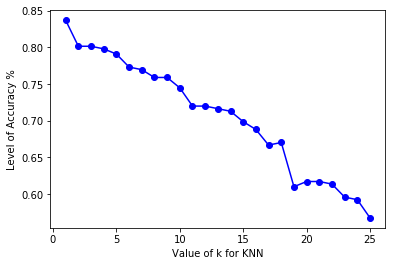

In [25]:
from sklearn import metrics
import matplotlib.pyplot as plt
plt.clf()
#search for best k of k-nearest nieghbors
k_range = range(1,26)
scores=[]
for k in k_range:
  knn=KNeighborsClassifier(metric='jaccard', n_neighbors=k)
  knn.fit(X_train,y_train)
  pred=knn.predict(X_test)
  scores.append(metrics.accuracy_score(y_test,pred) )
print(scores)

import matplotlib.pyplot as plt

plt.plot(k_range,scores,'bo-')
plt.xlabel('Value of k for KNN')
plt.ylabel('Level of Accuracy %')
plt.show()